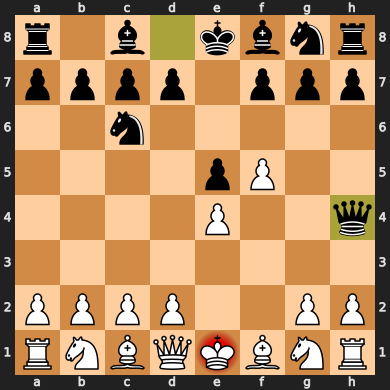

Best move: d8h4, Eval: -1.569999999999272
Your move:
Invalid move. Try again:
Total game time = 125.543 seconds


InvalidMoveError: expected uci string to be of length 4 or 5: ''

In [15]:
import chess
from IPython.display import clear_output
from bot import Bot, game_manager
import test_bot

# Add promotion stuff

if __name__ == "__main__":

    chess_bot = Bot()  # you can enter a FEN here, like Bot("...")
    with game_manager():

        playing = True
        player_playing = True
        depth = 5

        while playing:
            if chess_bot.board.turn:
                if player_playing:
                    print(chess_bot.get_eval())
                    print("Your move:")
                    move = input()
                    while not chess.Move.from_uci(move) in chess_bot.board.legal_moves:
                        print("Invalid move. Try again:")
                        move = input()
                    clear_output()
                    chess_bot.board.push_san(move)
                else:
                    chess_bot.board.push_san(test_bot.get_move(chess_bot.board))
            else:
                chess_bot.board.push_san(chess_bot.next_move(depth))
            #print(chess_bot.board, end="\n\n")
            clear_output()
            display(chess_bot.board)
            print(chess_bot.get_eval())

            if chess_bot.board.is_game_over():
                if chess_bot.board.is_stalemate():
                    print("Is stalemate")
                elif chess_bot.board.is_insufficient_material():
                    print("Is insufficient material")

                # EX: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
                print(chess_bot.board.outcome())

                playing = False



## TT Testing

In [2]:
from bot import TranspositionTable
tt = TranspositionTable()
board = chess.Board('rnbqkb1r/pppppppp/7n/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 1 2')
print(tt.zobrist_hash(board))
board = chess.Board('rnbqkb1r/pppppppp/5n2/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 1 2')
print(tt.zobrist_hash(board))

2892945207429728887
7670125323384886094


In [29]:
from pieceTables import piece_tables, convert_piece_table, reverse_table
piece_tables = {piece: convert_piece_table(piece_table) for piece, piece_table in piece_tables.items()}
for square in chess.SQUARES:
    print(square, end=" ")
    print(piece_tables[chess.PAWN][square], end=" ")
    print(reverse_table(piece_tables[chess.PAWN])[square], end=" ")
    print(piece_tables[chess.KNIGHT][63 - square], end=" ")
    print()

0 0 0 -50 
1 0 0 -40 
2 0 0 -30 
3 0 0 -30 
4 0 0 -30 
5 0 0 -30 
6 0 0 -40 
7 0 0 -50 
8 5 50 -40 
9 10 50 -20 
10 10 50 0 
11 -20 50 0 
12 -20 50 0 
13 10 50 0 
14 10 50 -20 
15 5 50 -40 
16 5 10 -30 
17 -5 10 0 
18 -10 20 10 
19 0 30 15 
20 0 30 15 
21 -10 20 10 
22 -5 10 0 
23 5 10 -30 
24 0 5 -30 
25 0 5 5 
26 0 10 15 
27 20 25 20 
28 20 25 20 
29 0 10 15 
30 0 5 5 
31 0 5 -30 
32 5 0 -30 
33 5 0 0 
34 10 0 15 
35 25 20 20 
36 25 20 20 
37 10 0 15 
38 5 0 0 
39 5 0 -30 
40 10 5 -30 
41 10 -5 5 
42 20 -10 10 
43 30 0 15 
44 30 0 15 
45 20 -10 10 
46 10 -5 5 
47 10 5 -30 
48 50 5 -40 
49 50 10 -20 
50 50 10 0 
51 50 -20 5 
52 50 -20 5 
53 50 10 0 
54 50 10 -20 
55 50 5 -40 
56 0 0 -50 
57 0 0 -40 
58 0 0 -30 
59 0 0 -30 
60 0 0 -30 
61 0 0 -30 
62 0 0 -40 
63 0 0 -50 


## Evaluate Function Testing

f

In [2]:
from bot import Bot
import chess
b = Bot()
board = chess.Board()
board.push_san("e2e4")
board.push_san("e7e5")
board.push_san("g1f3")
board.push_san("h7h6")
board.push_san("f3e5")

print(b.evaluate(board))
print(b.get_ordered_moves(board))
print(board)

1.6499999999999995
[Move.from_uci('f7f6'), Move.from_uci('d7d6'), Move.from_uci('g8e7'), Move.from_uci('g8f6'), Move.from_uci('f8e7'), Move.from_uci('f8d6'), Move.from_uci('f8c5'), Move.from_uci('f8b4'), Move.from_uci('f8a3'), Move.from_uci('b8c6'), Move.from_uci('b8a6'), Move.from_uci('d7d5'), Move.from_uci('h8h7'), Move.from_uci('e8e7'), Move.from_uci('d8e7'), Move.from_uci('d8f6'), Move.from_uci('d8g5'), Move.from_uci('d8h4'), Move.from_uci('g7g6'), Move.from_uci('c7c6'), Move.from_uci('b7b6'), Move.from_uci('a7a6'), Move.from_uci('h6h5'), Move.from_uci('g7g5'), Move.from_uci('f7f5'), Move.from_uci('c7c5'), Move.from_uci('b7b5'), Move.from_uci('a7a5')]
r n b q k b n r
p p p p . p p .
. . . . . . . p
. . . . N . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B . R


## Bot vs Bot (testing)

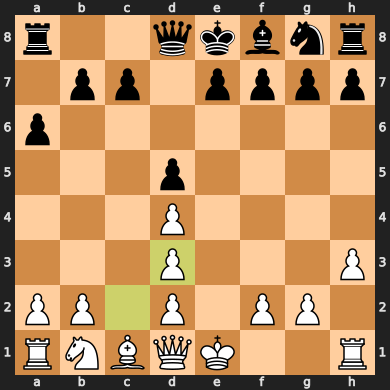

Best move: c2d3, Eval: -0.5350000000022552
Best move: e7e5, Eval: -1.1233606557398153
Best move: g8f6, Eval: -0.48459016393790044
Best move: d8d7, Eval: -1.0234426229511877
Best move: d8d7, Eval: 0.10704918032606692
Total game time = 117.116 seconds


KeyboardInterrupt: 

In [1]:
import chess
from IPython.display import clear_output
from bot import Bot, game_manager
from bot2 import Bot2
import test_bot

if __name__ == "__main__":
    fen = "rnbqkbnr/pppppppp/8/8/8/1P6/PBPPPPPP/RN1QKBNR"
    chess_bot = Bot2(fen)  # you can enter a FEN here, like Bot("...")
    original_bot = Bot(fen)
    with game_manager():
        playing = True
        player_playing = False
        depth = 5

        while playing:

            if chess_bot.board.turn:
                if player_playing:
                    print(chess_bot.get_eval())
                    print("Your move:")
                    move = input()
                    while not chess.Move.from_uci(move) in chess_bot.board.legal_moves:
                        print("Invalid move. Try again:")
                        move = input()
                    clear_output()
                    chess_bot.board.push_san(move)
                    original_bot.board.push_san(move)
                else:
                    move = chess_bot.next_move(depth)
                    chess_bot.board.push_san(move)
                    original_bot.board.push_san(move)
            else:
                move = original_bot.next_move(10)
                original_bot.board.push_san(move)
                chess_bot.board.push_san(move)

            clear_output()
            display(chess_bot.board)
            print(chess_bot.get_eval()) 

            if chess_bot.board.is_game_over():
                if chess_bot.board.is_stalemate():
                    print("Is stalemate")
                elif chess_bot.board.is_insufficient_material():
                    print("Is insufficient material")

                # EX: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
                print(chess_bot.board.outcome())
                playing = False

## Export PGN

In [1]:
import chess.pgn
pgn = chess.pgn.Game()   
pgn.headers["White"] = 'Me'
pgn.headers["Black"] = 'Chess Bot'

node = pgn

board = chess.Board()

for move in chess_bot.board.move_stack:
    board.push(move)
    node = node.add_variation(move)
    original_bot.transposition_table.zobrist_hash(board)
    print(original_bot.evaluate(board))
    print(original_bot.get_ordered_moves(board))
    print(board)

with open("chess_game.pgn", "w") as pgn_file:
    pgn_file.write(str(pgn))

NameError: name 'chess_bot' is not defined

In [1]:
import chess
from bot import Bot
board = chess.Board()
board.push_san("e4")
board.push_san("Nf6")
bot = Bot()

print(bot.get_endgame_weight(board))
print(bot.get_ordered_moves(board))

0.0
g1h3 P 13
g1f3 K 4
g1f3 P 11
g1f3 P 15
g1e2 B 2
f1a6 p 49
f1b5 p 51
f1c4 P 8
f1c4 p 53
f1d3 P 10
f1d3 P 28
f1e2 Q 3
e1e2 Q 3
e1e2 B 5
e1e2 P 11
e1e2 P 13
d1h5 P 15
d1h5 p 53
d1h5 p 55
d1g4 P 14
d1g4 P 28
d1f3 P 13
d1f3 P 14
d1f3 P 28
d1e2 K 4
d1e2 B 5
d1e2 P 11
d1e2 P 13
d1e2 P 28
b1c3 Q 3
b1c3 P 8
b1c3 P 28
b1a3 P 10
e4e5 n 45
f2f3 P 28
d2d3 P 28
[Move.from_uci('e4e5'), Move.from_uci('f1d3'), Move.from_uci('d1g4'), Move.from_uci('d1f3'), Move.from_uci('d1e2'), Move.from_uci('b1c3'), Move.from_uci('f2f3'), Move.from_uci('d2d3'), Move.from_uci('g1h3'), Move.from_uci('g1f3'), Move.from_uci('g1e2'), Move.from_uci('f1a6'), Move.from_uci('f1b5'), Move.from_uci('f1c4'), Move.from_uci('f1e2'), Move.from_uci('b1a3'), Move.from_uci('d2d4'), Move.from_uci('e1e2'), Move.from_uci('d1h5'), Move.from_uci('h2h3'), Move.from_uci('g2g3'), Move.from_uci('c2c3'), Move.from_uci('b2b3'), Move.from_uci('a2a3'), Move.from_uci('h2h4'), Move.from_uci('g2g4'), Move.from_uci('f2f4'), Move.from_uci('c2c4'), M

## Other Testing

In [6]:
fen = "rnbqkbnr/pp2pppp/2p5/3p4/8/4PN2/PPPP1PPP/RNBQKB1R"
board = chess.Board(fen)
from bot import Bot
bot = Bot()
print(bot.get_ordered_moves(board))
print(board)

        
        

[Move.from_uci('b1c3'), Move.from_uci('f1d3'), Move.from_uci('c2c4'), Move.from_uci('f1b5'), Move.from_uci('f1c4'), Move.from_uci('f3e5'), Move.from_uci('f3d4'), Move.from_uci('f1e2'), Move.from_uci('d1e2'), Move.from_uci('h1g1'), Move.from_uci('f1a6'), Move.from_uci('e1e2'), Move.from_uci('b1a3'), Move.from_uci('f3g5'), Move.from_uci('f3h4'), Move.from_uci('f3g1'), Move.from_uci('d2d4'), Move.from_uci('e3e4'), Move.from_uci('d2d3'), Move.from_uci('h2h4'), Move.from_uci('a2a4'), Move.from_uci('h2h3'), Move.from_uci('a2a3'), Move.from_uci('g2g3'), Move.from_uci('b2b3'), Move.from_uci('g2g4'), Move.from_uci('b2b4'), Move.from_uci('c2c3')]
r n b q k b n r
p p . . p p p p
. . p . . . . .
. . . p . . . .
. . . . . . . .
. . . . P N . .
P P P P . P P P
R N B Q K B . R


In [4]:
attackers = board.attackers(king.color, s)
print(attackers)


. . . 1 . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
